In [1]:
import torch
import torch.nn

from dataset.data import DataLoader


In [2]:
my_loader= DataLoader(dataset_name='CIFAR10', batch_size=128)
train_loader, test_loader = my_loader.get_loader()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from models.resnet import ResNet18
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

my_model1 = ResNet18(num_class=10).to(device)

summary(my_model1, input_size=(3,32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [4]:
from main.train import TrainModel
from main.eval import TestModel
from torch.optim.lr_scheduler import StepLR 
import torch.optim as optim

EPOCHS = 1

In [5]:
my_model1 = my_model1 = ResNet18(num_class=10).to(device)
optimizer1 = optim.SGD(my_model1.parameters(), lr=0.01, momentum=0.9)
scheduler1 = StepLR(optimizer1, step_size=20, gamma=0.1) 

train_module1 = TrainModel(my_model1, device, train_loader, optimizer1)
test_module1 = TestModel(my_model1, device, test_loader)

In [6]:
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    train_module1.train_a(L1_reg=False, l1_lambda=0.0001) # batch norm model with L1 regularization.
    test_module1.test()
    scheduler1.step()
    

EPOCH: 0


Loss=1.4446641206741333 Batch_id=390 Accuracy=43.21: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Test set: Average loss: 1.1246, Accuracy: 5984/10000 (59.84%)



In [8]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import os

def plot_misclassified_v2(test_misc_img, test_misc_label, subtitle='misclassified images'):
# Set the number of rows and columns for the plot
  num_rows = 5
  num_cols = 2

  # Create a figure and axes for the plot
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

  # Iterate over the mis-classified images and labels
  for i, (img, (pred_label, true_label)) in enumerate(zip(test_misc_img, test_misc_label)):
      # Get the row and column index for the current image
      row = i // num_cols
      col = i % num_cols
      img = img / 2 + 0.5
      npimg = img.to('cpu').numpy()
      axes[row, col].imshow(np.transpose(npimg, (1, 2, 0)))

      # Plot the image and label on the current axes
      #axes[row, col].imshow(img.to('cpu').squeeze(), cmap='gray')
      axes[row, col].set_title(f'Pred: {pred_label}, True: {true_label}')
      # remove axis labels
      axes[row, col].axis('off')
      
  plt.suptitle(subtitle)
  if not os.path.exists("report"):
      os.makedirs("report")
  plt.savefig("report/" + subtitle + ".png")
  plt.show()

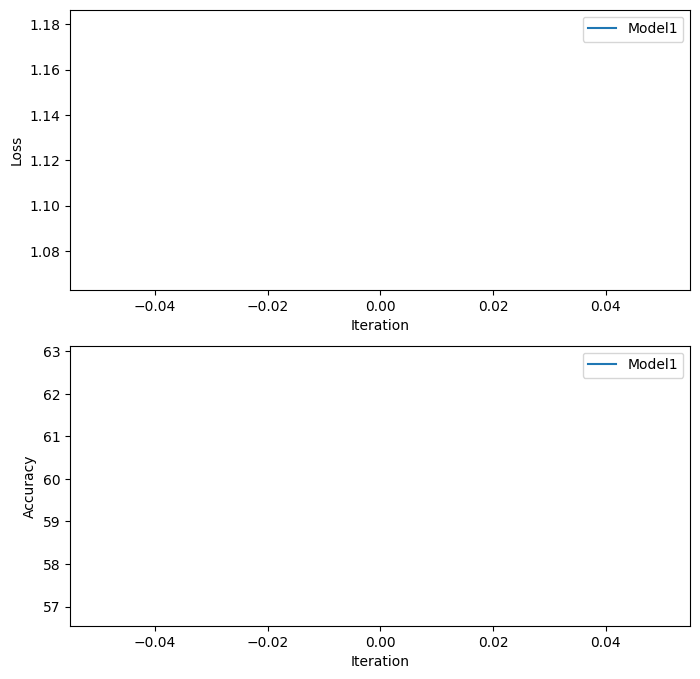

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

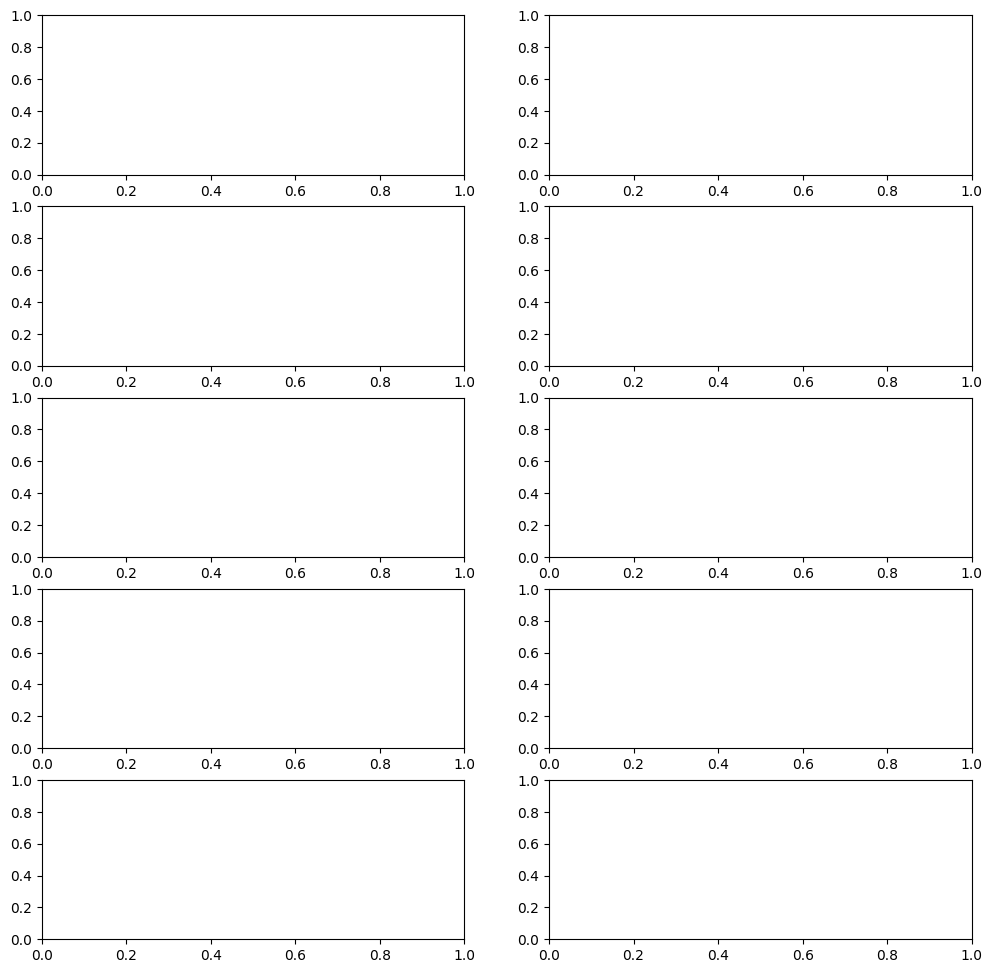

In [9]:
from util.plot_graph import plot_loss_accuracy

plot_loss_accuracy(test_module1)

#from util.plot_misclassified import plot_misclassified
plot_misclassified_v2(test_module1.test_misc_img, test_module1.test_misc_label, 'model1_misclassified')

In [ ]:
state = my_model1.state_dict()

In [ ]:
import os

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')

In [ ]:
checkpoint = torch.load('./checkpoint/ckpt.pth')
my_model1.load_state_dict(checkpoint)
target_layer4 = [my_model1.layer4[-1]]
target_layer3 = [my_model1.layer3[-1]]
target_layer2 = [my_model1.layer2[-1]]

In [ ]:
from torchvision import datasets, transforms
import numpy as np

my_cifar10_test = datasets.CIFAR10(root='./data/', train=False, transform=None)
rgb_img = my_cifar10_test[100][0].convert('RGB')
rgb_plot = rgb_img
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

input_tensor = transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()




In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
import torchvision.transforms as T
from PIL import Image


cam4 = GradCAM(model=my_model1, target_layers=target_layer4, use_cuda=True)
cam3 = GradCAM(model=my_model1, target_layers=target_layer3, use_cuda=True)
cam2 = GradCAM(model=my_model1, target_layers=target_layer2, use_cuda=True)

grayscale_cam4 = cam4(input_tensor=input_tensor)
grayscale_cam3 = cam3(input_tensor=input_tensor)
grayscale_cam2 = cam2(input_tensor=input_tensor)
grayscale_cam4 = grayscale_cam4[0, :]
grayscale_cam3 = grayscale_cam3[0, :]
grayscale_cam2 = grayscale_cam2[0, :]

visualization4 = show_cam_on_image(rgb_img, grayscale_cam4, use_rgb=True)
visualization3 = show_cam_on_image(rgb_img, grayscale_cam3, use_rgb=True)
visualization2 = show_cam_on_image(rgb_img, grayscale_cam2, use_rgb=True)

In [ ]:
Image.fromarray(visualization4, 'RGB')

In [ ]:
Image.fromarray(visualization3, 'RGB')

In [ ]:
Image.fromarray(visualization2, 'RGB')

In [ ]:
rgb_plot.show()